<a href="https://colab.research.google.com/github/akamojo/QRS-Detector/blob/master/QRSdetector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Second assignment part 2
The objetive of this work is to construct a suitable Neural Network in order to preview the QRS signal based on ECG (electrocardiogram) signals.    
  
To do this is what we will do:
  1. Download the files from the physionet website with a package from wfdb library  
  
  2. We will read thoose files and storage and signals as numpy arrays.  
  
  3. Then we will use them in different types of Neural Networks.  
  
  4. Then we will compare the results from different Neural Networks
  

In [1]:
!pip install wfdb

     |████████████████████████████████| 102kB 4.9MB/s 
  Stored in directory: /root/.cache/pip/wheels/bb/a9/00/0078d26b0c15b31be0001af8eb659496709c361c69641303f1
Successfully built wfdb


# 1.Downloading the records  
In order to download the files:
  - Get the record names list
  - Now lets download all the files to the data_folder.

In [2]:
import wfdb
import os
import pandas as pd
from wfdb import io, plot
import numpy as np

record_names = io.get_record_list('incartdb')
data_folder = 'data'
io.dl_database('incartdb', data_folder, record_names)

Created local base download directory: data
Detected partially downloaded file: data/I38.dat Appending file...
headers:  {'Range': 'bytes=6361088-', 'Accept-Encoding': '*/*'}
r content length:  4741312
Done appending.
Finished downloading files


# 2. Reading the files and convert the signal information into a Numpy array
## 2.1 Reading just one file
In order to read a simple file it can be used the io.rdrecord() method. The objetive of reading a single file is to understand what is the format of the files

In [0]:
# import wfdb

# base_dir = '/content/drive/My Drive/STUDIA/SEM 8/adne/'
# record = wfdb.rdrecord(base_dir + 'I01') 

record_name = record_names[0]
record = wfdb.rdrecord('data/' + record_name, channels=[1,6])

### 2.1.1 Getting the signal's information into a Numpy 2D tensor
With the record.p_signal we will get the a numpy tensor with the following caracteristics:
Rows: each correspond to a moment of record.
Columns: each column corresponds to a different signal.

In [6]:
record.p_signal.shape

(462600, 2)

### 2.1.2 Get the signals names, or if you prefer the name of the columns of the previous Numpy 2D tensor

In [0]:
record.sig_name

['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

### 2.1.3 Get the coments of the signal. 
This will be used in order to get the label of each record.

In [0]:
record.comments

['<age>: 65 <sex>: F <diagnoses> Coronary artery disease, arterial hypertension',
 'patient 1',
 'PVCs, noise']

In [0]:
import numpy as np
import tensorflow as tf
from tensorflow.python.keras import layers
import matplotlib.pyplot as plt

Use one ECG record alredy converted to 'npy' format and using sampling rate=125 Hz

ECG shape:  (2, 462600)


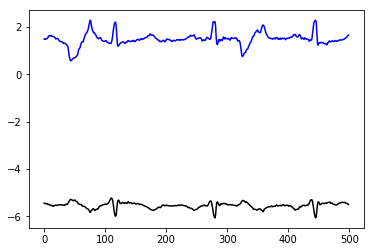

In [9]:
#ecg = np.load(base_dir + 'sel116.npy')
ecg = np.transpose(record.p_signal)
ecg=ecg.astype(np.float32)
print('ECG shape: ', ecg.shape)
t = range(500)
plt.plot(t,ecg[0,t],'b',t,ecg[1,t]-2,'k')
plt.show()

## 2.2 Now Let's Load all the records  
In order to load all the records Numpy 2darrays into a huge Numpy 2darray with the values from all the record:
  1.  Let's check if all the files have the same columns format
  2.  Let's iterate throught all the files extra the numpy 2darray and append it to main numpy 2d array.

In [29]:
from tqdm import tqdm_notebook as tqdm

# possible symbols
possibleAnn = ['N','L','R','B','A','a','J','S','V','r','F','e','j','n','E','/','f','Q',' ?']

#data = np.zeros((1,len(record.sig_name)))
data = []

for record_name in tqdm(record_names):
    ann = wfdb.rdann(os.path.join('data', record_name), 'atr')
    
    if not set(ann.symbol) <= set(possibleAnn):
        print('skipping', record_name)
        continue

    record = io.rdrecord(record_name=os.path.join('data', record_name), channels=[1, 6])
    data.append(np.transpose(record.p_signal))
    #data = np.vstack([data,record.p_signal])
    
    
#data=np.delete(data,(0),axis=0)
data = np.array(data)
print(data.shape)

skipping I49
skipping I50
skipping I68
skipping I69
skipping I70
skipping I71

(69, 2, 462600)


# Task:
We want to create network that receives a segment of the first ecg channel (blue) and returns the corresponding segment of the second channel (black). The segment length must be fixed.






In [0]:
# auxiliary function
# extracts from a long np-array (2-rows) a (2-rows)-random segment with a fixed length (seqL*ninputs)
def selectFrom1ecg(ecgBdata,seqL, ninputs):
    """ecgBdata.shape=(1,112500) 
    seqL:  number of timesteps to be used in recurrent nn
    ninput : is number of inputs in each timestep
    """
    segmentL  = seqL * ninputs
    numChan = 2
    inpOutSegment = tf.random_crop(ecgBdata,[numChan, segmentL])
    inputs = inpOutSegment[0,:]
    target = inpOutSegment[1,:]
    return inputs,target


In [0]:
from random import randint

def selectFromData(ecgBdata,seqL, ninputs):
    segmentL  = seqL * ninputs
    numChan = 2
    inpOutSegment = tf.random_crop(ecgBdata[randint(0, ecgBdata.shape[0]), :, :],[numChan, segmentL])
    inputs = inpOutSegment[0,:]
    target = inpOutSegment[1,:]
    return inputs,target


Let's divide the ECG data in three parts: first part for training, second for validation and last and last part for testing.

A tensorflow 'Dataset' can be used to represent an input pipeline as a collection of elements (nested structures of tensors) and a "logical plan" of transformations that act on those elements.

In [14]:
N = data.shape[1]
seqL = 20
fs = 125
ninputs = int(0.2*fs)

# training data
trainData =tf.data.Dataset.from_tensors(data[:, :, :N-10000])
trainData = trainData.map(lambda x:  selectFromData(x,seqL, ninputs))
trainData = trainData.repeat()  # Repeat the input indefinitely.
batchSize = 8
trainData = trainData.batch(batchSize)

# validation data
valData =tf.data.Dataset.from_tensors(data[:, :, N-10000:N-5000])
valData = valData.map(lambda x:  selectFromData(x,seqL, ninputs))
valData = valData.repeat()  # Repeat the input indefinitely.
batchSize = 8
valData = valData.batch(batchSize)

# test data
testData =tf.data.Dataset.from_tensors(data[:, :, N-5000:])
testData = testData.map(lambda x:  selectFromData(x,seqL, ninputs))
testData = testData.repeat()  # Repeat the input indefinitely.
batchSize = 8
testData = testData.batch(batchSize)

Instructions for updating:
Colocations handled automatically by placer.


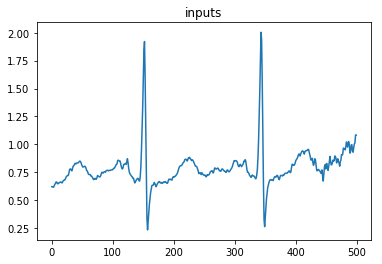

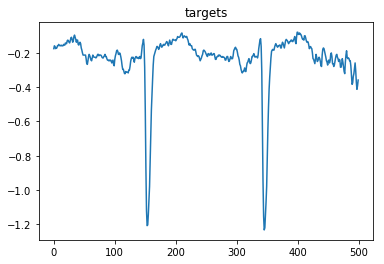

In [16]:
# let's visualize the model's input data and target data
iterator = trainData.make_initializable_iterator()
next_element = iterator.get_next()
with tf.Session() as sess:
    sess.run(iterator.initializer)
    inp, targ = sess.run(next_element)
plt.plot(inp[0,:])
plt.title('inputs')
plt.show()
plt.plot(targ[0,:])
plt.title('targets')
plt.show()

# MLP model


In [17]:
ffwdModel = tf.keras.Sequential()
ffwdModel.add(layers.Dense(64, activation='relu',input_shape=(seqL*ninputs,)))
ffwdModel.add(layers.Dense(64, activation='relu'))
ffwdModel.add(layers.Dense(seqL*ninputs))

ffwdModel.compile(optimizer=tf.train.RMSPropOptimizer(0.001), loss='MSE',metrics=['mae'])
ffwdModel.fit(trainData,  epochs=10, steps_per_epoch=1000, validation_data=valData, validation_steps=100)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
1000/1000 [==============================] - 16s 16ms/step - loss: 0.3972 - mean_absolute_error: 0.4681 - val_loss: 0.2454 - val_mean_absolute_error: 0.4625
Epoch 2/10
1000/1000 [==============================] - 15s 15ms/step - loss: 0.3253 - mean_absolute_error: 0.4205 - val_loss: 0.3397 - val_mean_absolute_error: 0.5519
Epoch 3/10
1000/1000 [==============================] - 16s 16ms/step - loss: 0.3305 - mean_absolute_error: 0.4207 - val_loss: 0.3791 - val_mean_absolute_error: 0.5888
Epoch 4/10
1000/1000 [==============================] - 15s 15ms/step - loss: 0.3046 - mean_absolute_error: 0.4073 - val_loss: 0.4154 - val_mean_absolute_error: 0.6158
Epoch 5/10
1000/1000 [==============================] - 15s 15ms/step - loss: 0.3005 - mean_absolute_error: 0.4061 - val_loss: 0.4720 - val_mean_absolute_error: 0.6568
Epoch 6/10
1000/1000 [==============================] - 15s 15ms

500/500 [==============================] - 1s 2ms/step - loss: 11.1840 - mean_absolute_error: 3.3410
test mean square error (loss):  11.183983907699584   test absolute error:  3.3409712


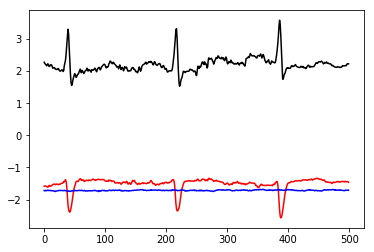

In [18]:
out = ffwdModel.evaluate(testData, steps=500)
print('test mean square error (loss): ', out[0], '  test absolute error: ', out[1])
iterator = trainData.make_initializable_iterator()
next_element = iterator.get_next()
with tf.Session() as sess:
    sess.run(iterator.initializer)
    inp, targ = sess.run(next_element)
output = ffwdModel.predict(inp)
t = range(seqL*ninputs)
plt.plot(t,inp[0,:],'k',t,targ[0]-2,'r',t,output[0]-2,'b')
plt.show()

# Recurrent model


In [19]:
numLstmUnits = 32
denseDim = ninputs
rnnModel = tf.keras.Sequential()
rnnModel.add(layers.Reshape((seqL,ninputs), input_shape=(seqL*ninputs,)))
rnnModel.add(layers.CuDNNLSTM(units=numLstmUnits, return_sequences=True))         
rnnModel.add(layers.CuDNNLSTM(units=numLstmUnits, return_sequences=True))
rnnModel.add(layers.TimeDistributed(layers.Dense(denseDim)))
rnnModel.add(layers.Reshape((seqL*ninputs,)))

rnnModel.compile(optimizer=tf.train.RMSPropOptimizer(0.001), loss='MSE',metrics=['mae'])
rnnModel.fit(trainData,  epochs=10, steps_per_epoch=1000, validation_data=valData, validation_steps=100)

Epoch 1/10
1000/1000 [==============================] - 18s 18ms/step - loss: 0.3471 - mean_absolute_error: 0.4359 - val_loss: 0.4838 - val_mean_absolute_error: 0.6633
Epoch 2/10
1000/1000 [==============================] - 13s 13ms/step - loss: 0.2900 - mean_absolute_error: 0.3958 - val_loss: 0.5413 - val_mean_absolute_error: 0.7059
Epoch 3/10
1000/1000 [==============================] - 13s 13ms/step - loss: 0.2712 - mean_absolute_error: 0.3866 - val_loss: 0.5146 - val_mean_absolute_error: 0.6896
Epoch 4/10
1000/1000 [==============================] - 14s 14ms/step - loss: 0.2644 - mean_absolute_error: 0.3742 - val_loss: 0.5174 - val_mean_absolute_error: 0.6938
Epoch 5/10
1000/1000 [==============================] - 13s 13ms/step - loss: 0.2650 - mean_absolute_error: 0.3732 - val_loss: 0.4919 - val_mean_absolute_error: 0.6719
Epoch 6/10
1000/1000 [==============================] - 13s 13ms/step - loss: 0.2596 - mean_absolute_error: 0.3683 - val_loss: 0.4146 - val_mean_absolute_error:

500/500 [==============================] - 2s 4ms/step - loss: 17.8471 - mean_absolute_error: 4.2215
test mean square error (loss):  17.847071483612062   test absolute error:  4.2215443


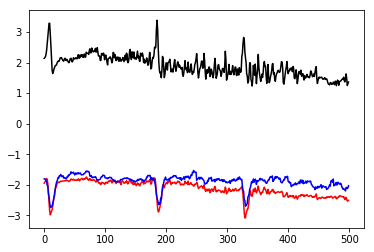

In [30]:
rnnModel.compile(optimizer=tf.train.RMSPropOptimizer(0.001), loss='MSE',metrics=['mae'])
out = rnnModel.evaluate(testData, steps=500)
print('test mean square error (loss): ', out[0], '  test absolute error: ', out[1])
iterator = trainData.make_initializable_iterator()
next_element = iterator.get_next()
with tf.Session() as sess:
    sess.run(iterator.initializer)
    inp, targ = sess.run(next_element)
output = rnnModel.predict(inp)
t = range(seqL*ninputs)
plt.plot(t,inp[0,:],'k',t,targ[0]-2,'r',t,output[0]-2,'b')
plt.show()